# Automated Georeferencing

In [34]:
import argparse
from pathlib import Path

import numpy as np
import cv2

from historef.center import get_fiducial_mark_centers
from historef.grid import \
    construct_grid_graph, \
    identify_scale_factor, \
    identify_rotation_angle,\
    plot_edges
from historef.transform import \
    find_overlapping_transform, \
    apply_transform_points,\
    find_nearest_pairs
from historef.util import intensity_cut
from historef.matchraster import \
    find_best_transform_eff, preprocess_image,\
    warp_from_gcps
from historef.referencer import *

%load_ext autoreload
%autoreload 2
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ngef  = "../sample/b02a/N3-HG5MC.B02A.human.sge_match_sbcd.png"   ## nbcd-nmatch-nge 3way image
hnef = "../sample/b02a/histology_crop.tif" 
alignf = "../sample/b02a/output/histology_aligned.tif" 

 
params = {
    'nge_xy_swap': True,
    'nge_center_channel': 0,
    'nge_center_template': 'sbcd',
    'nge_center_min_dist': 200,
    'hne_xy_swap': True,
    'hne_center_channel': 0,
    'hne_center_template': 'HnE_121',
    'hne_center_min_dist': 300,
    'matching_max_nearest': 0.33,
    'nge_raster_channel':1,
    'nge_raster_blur':5,
    'nge_raster_gamma':2,
    'hne_raster_channel':1,
    'hne_raster_blur':5,
    'hne_raster_gamma':2,
    'matched_pair_max_distance': 100
}


/home/yongha/repo/historef/historef/template/fiducial_mark.sbcd.png


detected 336 fiducial marks and skipped 0


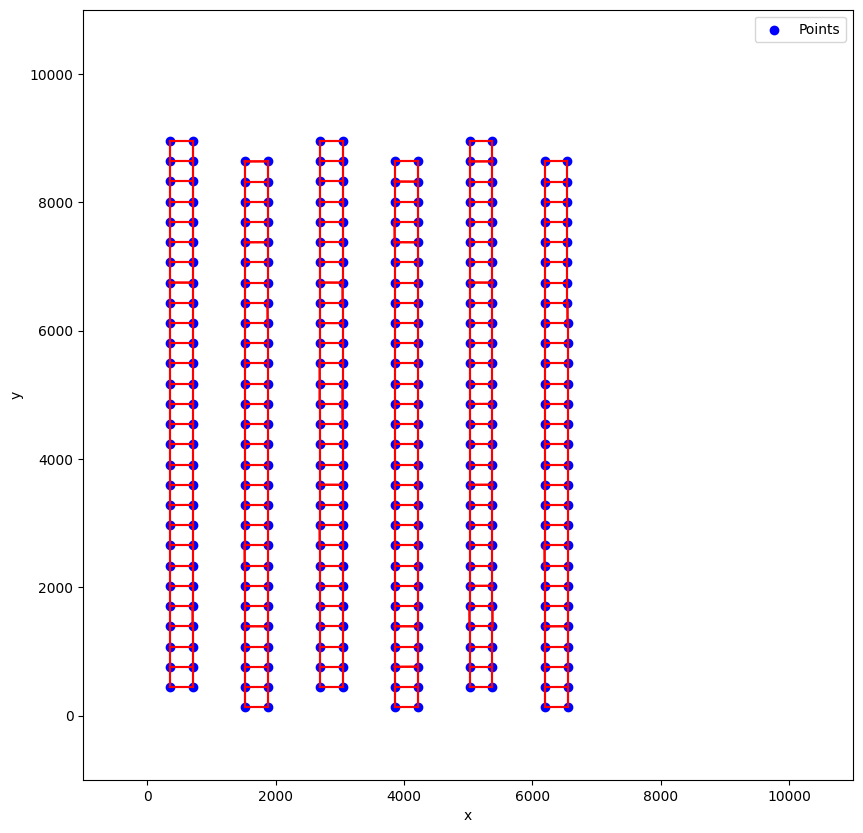

In [5]:
output_dir = Path(alignf).parent

im_nge_raw = cv2.imread(ngef, cv2.IMREAD_COLOR)
im_nge = preprocess_image(
    im_nge_raw, 
    channel=params['nge_center_channel'], 
    xy_swap=params['nge_xy_swap'])
circles_nge, _ = get_fiducial_mark_centers(
    im_nge, 
    params['nge_center_template'], 
    min_dist=params['nge_center_min_dist'])
v_nge, e_nge = construct_grid_graph(circles_nge)
plot_edges(v_nge, e_nge)

/home/yongha/repo/historef/historef/template/fiducial_mark.HnE_121.png


Skipped a fiducial mark at (1900, 1034) with (505, 521)
Skipped a fiducial mark at (862, 6380) with (447, 268)
Skipped a fiducial mark at (375, 1863) with (510, 666)
Skipped a fiducial mark at (1903, 1445) with (465, 394)
Skipped a fiducial mark at (378, 2684) with (447, 421)
Skipped a fiducial mark at (1898, 623) with (530, 431)
Skipped a fiducial mark at (376, 2273) with (436, 312)
Skipped a fiducial mark at (6951, 602) with (531, 428)
Skipped a fiducial mark at (381, 3094) with (417, 362)
Skipped a fiducial mark at (852, 3914) with (305, 158)
Skipped a fiducial mark at (3434, 2260) with (343, 169)
Skipped a fiducial mark at (6949, 190) with (453, 411)
Skipped a fiducial mark at (1905, 2266) with (380, 211)
Skipped a fiducial mark at (1896, 212) with (402, 318)
Skipped a fiducial mark at (845, 2682) with (503, 513)
Skipped a fiducial mark at (2404, 9659) with (354, 206)
Skipped a fiducial mark at (859, 5558) with (357, 182)
Skipped a fiducial mark at (879, 10486) with (257, 121)
Skip

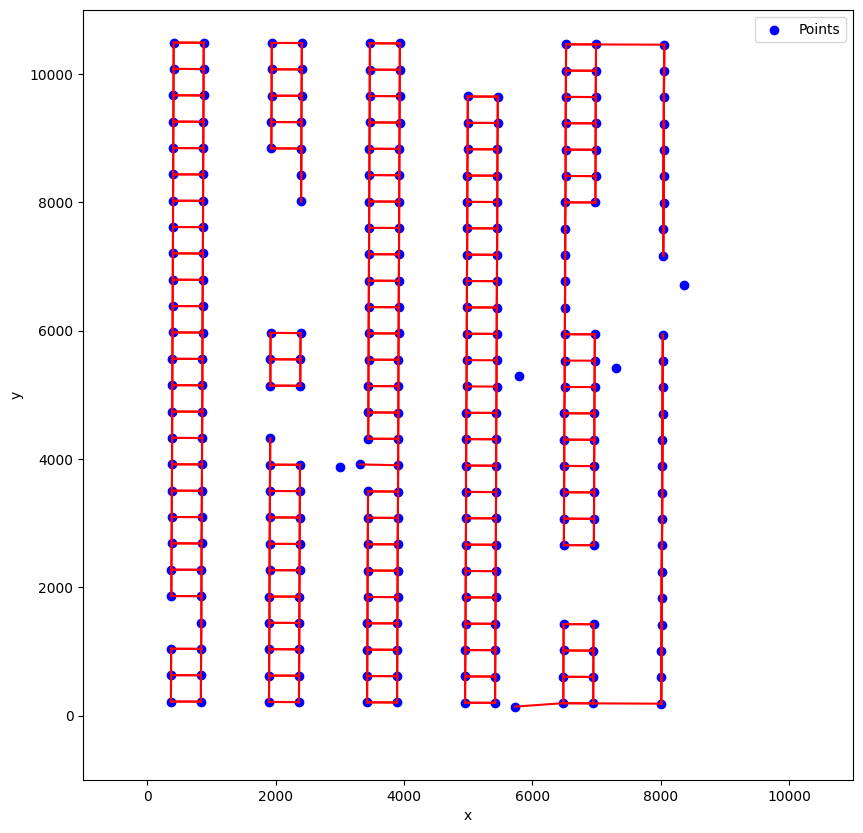

In [6]:
im_hne_raw = cv2.imread(hnef, cv2.IMREAD_COLOR)
im_hne = intensity_cut(im_hne_raw)
im_hne = preprocess_image(
    im_hne, 
    xy_swap=params['hne_xy_swap'])
circles_hne, _ = get_fiducial_mark_centers(
    im_hne, 
    params['hne_center_template'],
    min_dist=params['hne_center_min_dist'])
v_hne, e_hne = construct_grid_graph(circles_hne)
plot_edges(v_hne, e_hne)

In [7]:
scale_factor, xgrid_nge, xgrid_hne = \
    identify_scale_factor(e_nge, e_hne)
rotation = identify_rotation_angle(e_hne)
print(f"Scale Factor: {scale_factor}, Rotation Angle: {rotation}")

xgrid_1 / xgrid_2:: 315.5 / 411.5 = 0.7667071688942891
Rotation Angle 0.2416048454174953
Scale Factor: 0.7667071688942891, Rotation Angle: 0.2416048454174953


In [8]:
tms, avg_distances = find_overlapping_transform(
v_nge, v_hne, 
rotation, scale_factor, 
max_nearest=params['matching_max_nearest']*xgrid_nge)

In [9]:
nge_raster = preprocess_image(
    im_nge_raw, xy_swap=params['nge_xy_swap'], 
    channel=params['nge_raster_channel'], 
    blur=params['nge_raster_blur'], 
    gamma=params['nge_raster_gamma'])

hne_raster = preprocess_image(
    im_hne_raw, xy_swap=params['hne_xy_swap'], 
    channel=params['hne_raster_channel'], 
    blur=params['hne_raster_blur'], 
    gamma=params['hne_raster_gamma'])


In [11]:
best_tf, best_idx, errors  = \
    find_best_transform_eff(nge_raster, hne_raster, tms)
print(f"Best Transform (ID {best_idx}):", best_tf)
print("errors:", errors)
    

Number of clusters: 1021
Number of outlier points: 0
0
Best Transform: 131 (86.33100091200319)
Best Transform (ID 131): [[ 7.66700352e-01 -3.23304124e-03  6.06430940e+01]
 [ 3.23304124e-03  7.66700352e-01  5.95051902e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
errors: {'error_all_clusters': {0: [89.4292187051574, 89.41650356476246, 89.42118033028221, 89.3807943245745, 89.41054314363411], 1: [86.34889747975329, 86.37758676217334, 86.39861502344316, 86.37450346612017, 86.36773624536913], 2: [86.75416349995572, 86.74970489728375, 86.74900244126121, 86.76128622470347, 86.7468228353166], 3: [91.91260189924144, 91.91449083372845, 91.90020789570507, 91.91048817691616, 91.90730571303666]}, 'errors_best_cluster': [86.38045930071665, 86.38052781203653, 86.3945414983432, 86.38465014866495, 86.38148617424206, 86.38176103171996, 86.3665861406505, 86.37666408891897, 86.3673186002357, 86.37854501290066, 86.37032515150725, 86.38075000402516, 86.37993780567224, 86.38118577232969, 86.374503

In [43]:

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Extracting cluster IDs and corresponding errors
def plot_errors(clusters, comparison=None, dot_size=3):
    # Preparing data for plotting
    x_values = []
    y_values = []
    for cluster_id, errors in clusters.items():
        for error in errors:
            x_values.append(cluster_id)
            y_values.append(error)

    # Plotting cluster errors
    plt.figure(figsize=(6, 6))
    plt.scatter(
        x_values, y_values, 
        s=dot_size, label='Cluster Errors')

    if comparison:
        # Determining the x-coordinate for the comparison values
        comparison_x = max(clusters.keys()) + 1
        # Plotting comparison values
        plt.scatter(
            [comparison_x] * len(comparison), comparison, 
            color='red', s=dot_size,  label='Best Cluster')

    # Plot labels and title
    plt.xlabel('Cluster ID')
    plt.ylabel('Raster Differences')
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    plt.title('Comparison of Errors Between Clusters')
    plt.legend()
    plt.show()


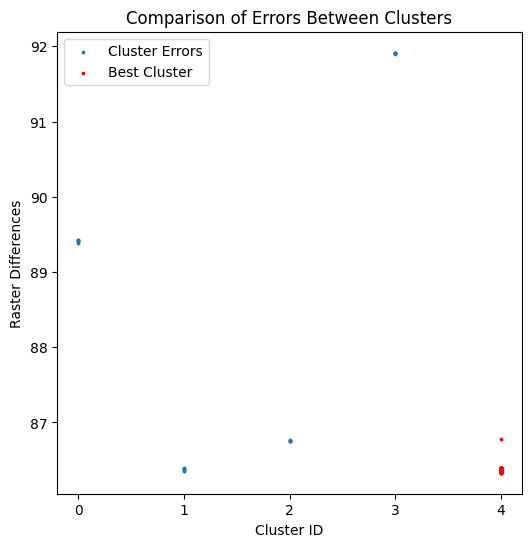

In [44]:
plot_errors(errors['error_all_clusters'], errors['errors_best_cluster'], dot_size=3)

In [ ]:
write_merged_image(nge_raster, hne_raster, best_tf) 